In [1]:
import numpy as np
from functools import reduce
from scipy.stats import wasserstein_distance, poisson, geom
from operator import concat
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.cluster.hierarchy as sch
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
import plotly.express as px
import plotly.graph_objects as go

cmap = get_cmap('tab10')(np.linspace(0,1,10))
sch.set_link_color_palette([rgb2hex(rgb[:3]) for rgb in cmap])


In [2]:
def encode(b,alphabet):
    return np.where(alphabet==b)[0][0]

def cantor(bs,alphabet):
    A = len(alphabet)
    return sum([2*encode(b,alphabet)/(2*A-1)**(l+1) for l,b in enumerate(bs)])

In [3]:
def PF_pairs(Xs,LP=2,LF=2):
    return ((wind[0:LP],wind[LP:LP+LF]) for wind in sliding_window_view(Xs,LP+LF))
    
def cantor_pairs(pairs):
    return ((cantor(reversed(p),alphabet),cantor(f,alphabet)) for p,f in tqdm(list(pairs),desc='Computing Cantor pairs'))
    
def CantorWasserstein(pairs):
    unq_pasts = []
    cantors = []
    ps,fs = zip(*pairs)
    f_cantors = np.array([cantor(b,alphabet) for b in tqdm(list(fs),desc='Cantor embedding futures')])
    unq_pasts = np.unique(np.array(list(ps)),axis=0)
    cantors = [f_cantors[np.where(np.all(past==ps,axis=1))] for past in tqdm(unq_pasts,desc='Building empirical dists')]
    pwass = np.array(list(reduce(concat,
        [
            [wasserstein_distance(cs_k,cs_l) for cs_l in cantors[k+1:]] 
            for k,cs_k in tqdm(list(enumerate(cantors)),desc='Evaluating condensed Wasserstein matrix')
        ]
    )))
    return unq_pasts,cantors,pwass

In [4]:
def scatter_cantor(Xs,LP=7,LF=7,figsize=(5,5)):
    xs,ys = zip(*cantor_pairs(PF_pairs(Xs,LP=LP,LF=LF)))
    _,ax = plt.subplots(figsize=figsize)
    plt.scatter(x=xs,y=ys,s=0.01,color='k')
    step = 1/(2*A-1)
    ax.set_xticks(np.arange(0,1+step,step))
    ax.set_xticks(np.arange(step/2,1,2*step),minor=True,)
    ax.set_yticks(np.arange(0,1+step,step))
    ax.set_yticks(np.arange(step/2,1,2*step),minor=True,)
    ax.tick_params('both',length=0,pad=10,which='minor')
    ax.set_yticklabels(['']*(2*A))
    ax.set_yticklabels(alphabet,minor=True,fontfamily='monospace')
    ax.set_xticklabels(['']*(2*A))
    ax.set_xticklabels(alphabet,minor=True,fontfamily='monospace')

In [5]:
def cluster_cantor(unq_pasts,cantors,wass,color_threshold=0,figsize=(18,14),dendro_rect=[0.09,0.1,0.2,0.8],dist_norm=np.sqrt,matrix_rect=[0.325,0.1,0.6,0.8],):
    alphabet = np.unique(Xs)
    A = len(alphabet)
    unq_pasts = np.array([''.join(s) for s in unq_pasts])
    Zpasts = sch.linkage(wass,method='ward')
    dist_range = np.linspace(0,np.max(Zpasts[:,2]),5)
    Zpasts[:,2] = (dist_norm(Zpasts[:,2]))
    
    fig = plt.figure(figsize=figsize)
    axdendro = fig.add_axes(dendro_rect)

    with plt.rc_context({'lines.linewidth': 1,}):
        Z = sch.dendrogram(Zpasts, orientation='left',color_threshold=dist_norm(color_threshold),above_threshold_color='k')
        
    axdendro.set_xticks(dist_norm(dist_range))
    axdendro.set_xticklabels((dist_range).astype("|S4").astype(str),rotation=45,fontsize=14,fontfamily='serif')
    axdendro.set_yticks([])
    axdendro.set_ylabel('Pasts',fontsize=25,fontfamily='serif')
    axdendro.set_xlabel('Distance',fontsize=20,fontfamily='serif')

    axdendro.spines['right'].set_visible(False)
    axdendro.spines['top'].set_visible(False)
    axdendro.spines['left'].set_visible(False)

    axmatrix = fig.add_axes(matrix_rect)
    for k,s in axmatrix.spines.items():
        s.set_color('k')
    index = Z['leaves']
    for k,j in enumerate(index):
        axmatrix.vlines(cantors[j],k,k+1,linewidth=0.1,color=Z['leaves_color_list'][k])

    axmatrix.hlines(np.arange(1,len(index)),0,1,linewidth=0.1,color='k')

    axmatrix.tick_params('both',length=0,pad=10,which='minor')

    axmatrix.set_ylim([0,len(index)])
    axmatrix.set_yticks([])
    axmatrix.set_yticks(np.arange(0.5,len(index),1),minor=True)
    axmatrix.set_yticklabels(unq_pasts[index],minor=True,fontfamily='monospace')

    step = 1/(2*A-1)
    axmatrix.set_xlim([0,1])
    axmatrix.set_xticks(np.arange(0,1+step,step))
    axmatrix.set_xticks(np.arange(step/2,1,2*step),minor=True,)
    axmatrix.set_xticklabels(['']*(2*A))
    axmatrix.set_xticklabels(alphabet,minor=True,fontsize=20,fontfamily='monospace')
    axmatrix.set_xlabel('Cantor-embedded futures',fontsize=25,fontfamily='serif')
    
    return Z, fig

# Even process

In [6]:
def gen_even(n_iter=100,p=0.5):
    lengths = geom.rvs(p=p,size=n_iter)-1
    return reduce(concat,map(lambda n:'0'+'11'*n,lengths,),'')

In [30]:
Xs = np.array([x for x in gen_even(100000)])
alphabet = np.unique(Xs)
A = len(alphabet)
print('N = ',Xs.shape[0])

N =  299836


Computing Cantor pairs: 100%|██████████| 9987/9987 [00:00<00:00, 12644.22it/s]


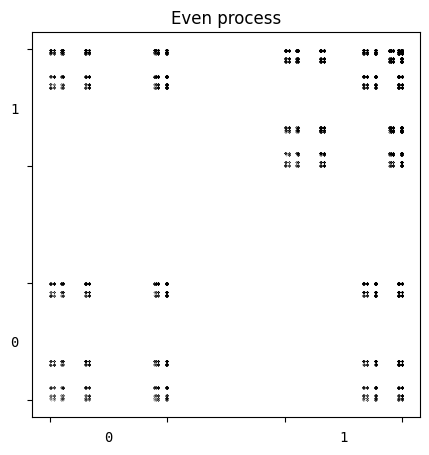

In [8]:
scatter_cantor(Xs[:10000],figsize=(5,5))
plt.title(r'Even process')
plt.savefig('../plots/even_CANTOR.png')
plt.show()

Evaluating condensed Wasserstein matrix: 100%|██████████| 54/54 [00:07<00:00,  7.30it/s]


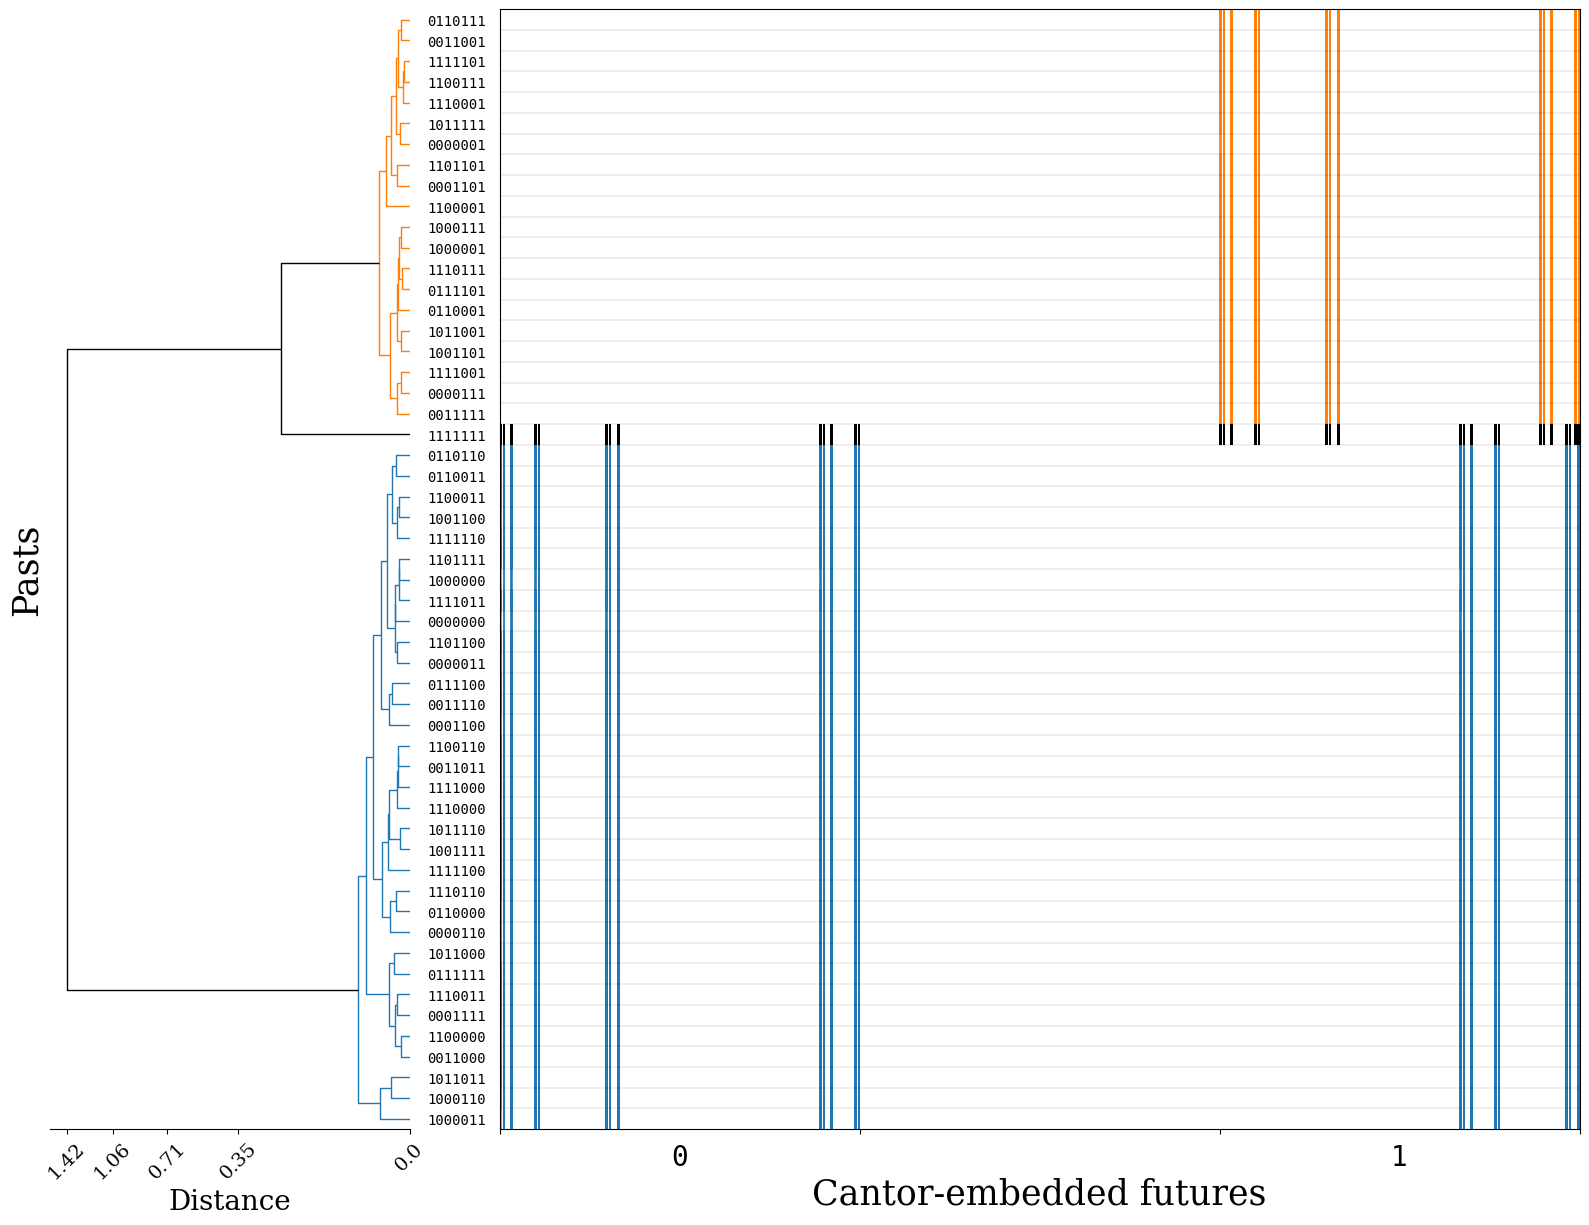

In [31]:
unq_pasts,cantors,wass = CantorWasserstein(PF_pairs(Xs,LP=7,LF=7),)
Z, fig = cluster_cantor(unq_pasts,cantors,wass,color_threshold=0.17,matrix_rect=[0.34,0.1,0.6,0.8])
plt.savefig('../plots/even_HCLUST.png')
plt.show()

In [32]:
colors_leaves = np.array(Z['leaves_color_list'])
colors = np.empty_like(colors_leaves)
colors[Z['leaves']] = colors_leaves

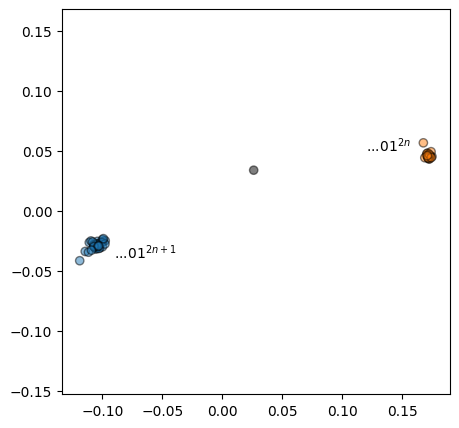

In [39]:
colors_leaves = np.array(Z['leaves_color_list'])
colors = np.empty_like(colors_leaves)
colors[Z['leaves']] = colors_leaves
Y = MDS(n_components=2,dissimilarity='precomputed',random_state=0).fit_transform(squareform(wass))
fig = plt.figure(figsize=(5,5))
plt.scatter(Y[:,0],Y[:,1],edgecolor='k',c=colors,alpha=0.5,)
plt.text(0.12, 0.05,r'...$01^{2n}$')
plt.text(-0.09, -0.04,r'...$01^{2n+1}$')
plt.axis('equal')
plt.savefig('../plots/even_MDS.pdf')
plt.show()


# $a^nb^n$ process

In [12]:
def gen_anbn(n_iter=100,mu=1):
    lengths = poisson.rvs(mu=mu,loc=1,size=n_iter)
    return reduce(concat,map(lambda n:'a'*n+'b'*n,lengths),'')

In [40]:
Xs = np.array([x for x in gen_anbn(500000)])
alphabet = np.unique(Xs)
A = len(alphabet)
print('N = ',Xs.shape[0])

N =  2000174


Computing Cantor pairs: 100%|██████████| 9987/9987 [00:00<00:00, 13654.66it/s]


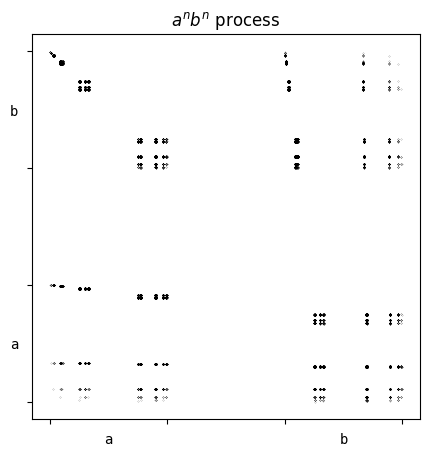

In [14]:
scatter_cantor(Xs[:10000],figsize=(5,5))
plt.title(r'$a^n b^n$ process')
plt.savefig('../plots/anbn_CANTOR.png')
plt.show()

Evaluating condensed Wasserstein matrix: 100%|██████████| 96/96 [00:30<00:00,  3.10it/s]


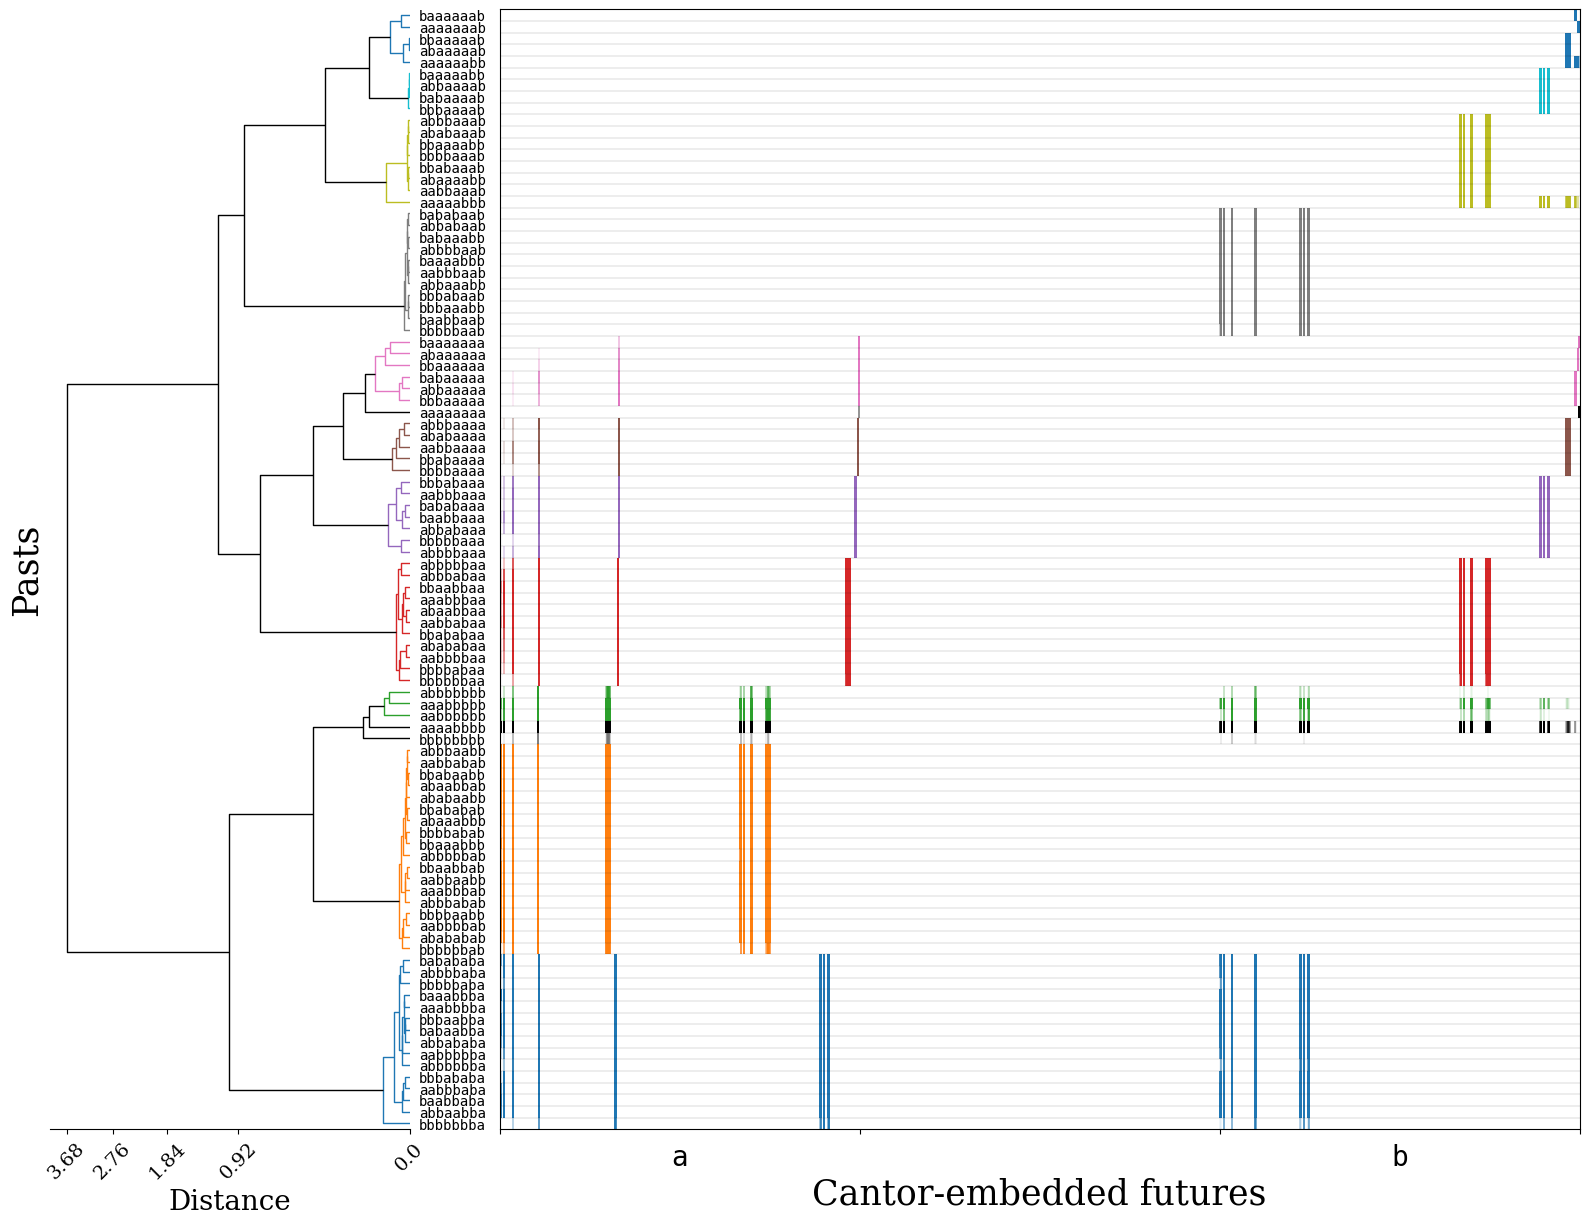

In [41]:
unq_pasts,cantors,wass = CantorWasserstein(PF_pairs(Xs,LP=8,LF=8),)
Z,fig = cluster_cantor(unq_pasts,cantors,wass,color_threshold=0.05,matrix_rect=[0.34,0.1,0.6,0.8])
plt.savefig('../plots/anbn_HCLUST.png')
plt.show()

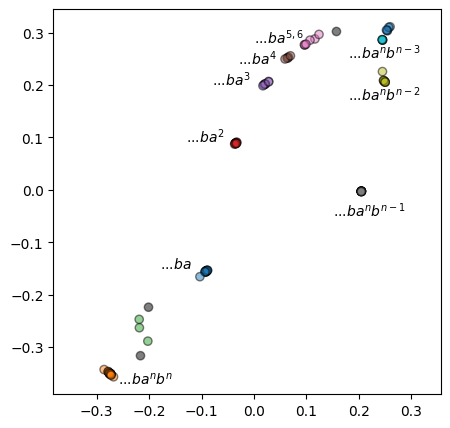

In [46]:
colors_leaves = np.array(Z['leaves_color_list'])
colors = np.empty_like(colors_leaves)
colors[Z['leaves']] = colors_leaves
Y = MDS(n_components=2,dissimilarity='precomputed',random_state=0).fit_transform(squareform(wass))
fig = plt.figure(figsize=(5,5))
plt.scatter(Y[:,0],Y[:,1],edgecolor='k',c=colors,alpha=0.5,)
plt.text(-0.26, -0.37,r'...$ba^{n}b^{n}$')
plt.text(-0.18, -0.15,r'...$ba$')
plt.text(-0.13, 0.09,r'...$ba^2$')
plt.text(-0.08, 0.2,r'...$ba^3$')
plt.text(-0.03, 0.24,r'...$ba^4$')
plt.text(0.00, 0.28,r'...$ba^{5,6}$')
plt.text(0.15, -0.05,r'...$ba^nb^{n-1}$')
plt.text(0.18, 0.17,r'...$ba^nb^{n-2}$')
plt.text(0.18, 0.25,r'...$ba^nb^{n-3}$')
plt.axis('equal')
plt.savefig('../plots/anbn_MDS.pdf')
plt.show()


# $a^n b^n c^n$ process

In [17]:
def gen_anbncn_poisson(n_iter=100,mu=1):
    lengths = poisson.rvs(mu=mu,loc=1,size=n_iter)
    return reduce(concat,map(lambda n:'a'*n+'b'*n+'c'*n,lengths),'')

In [18]:
Xs = np.array([x for x in gen_anbncn_poisson(400000)])
alphabet = np.unique(Xs)
A = len(alphabet)
print('N = ',Xs.shape[0])

N =  2400681


Computing Cantor pairs: 100%|██████████| 9987/9987 [00:00<00:00, 17309.12it/s]


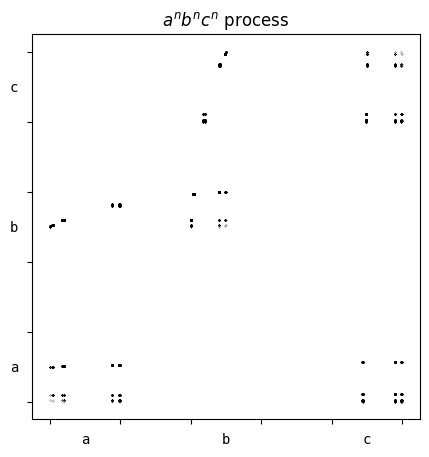

In [19]:
scatter_cantor(Xs[:10000],figsize=(5,5))
plt.title(r'$a^n b^n c^n$ process')
plt.savefig('../plots/anbncn_CANTOR.png')
plt.show()

In [20]:
unq_pasts,cantors,wass = CantorWasserstein(PF_pairs(Xs,LP=8,LF=8),)

Evaluating condensed Wasserstein matrix: 100%|██████████| 108/108 [00:35<00:00,  3.04it/s]


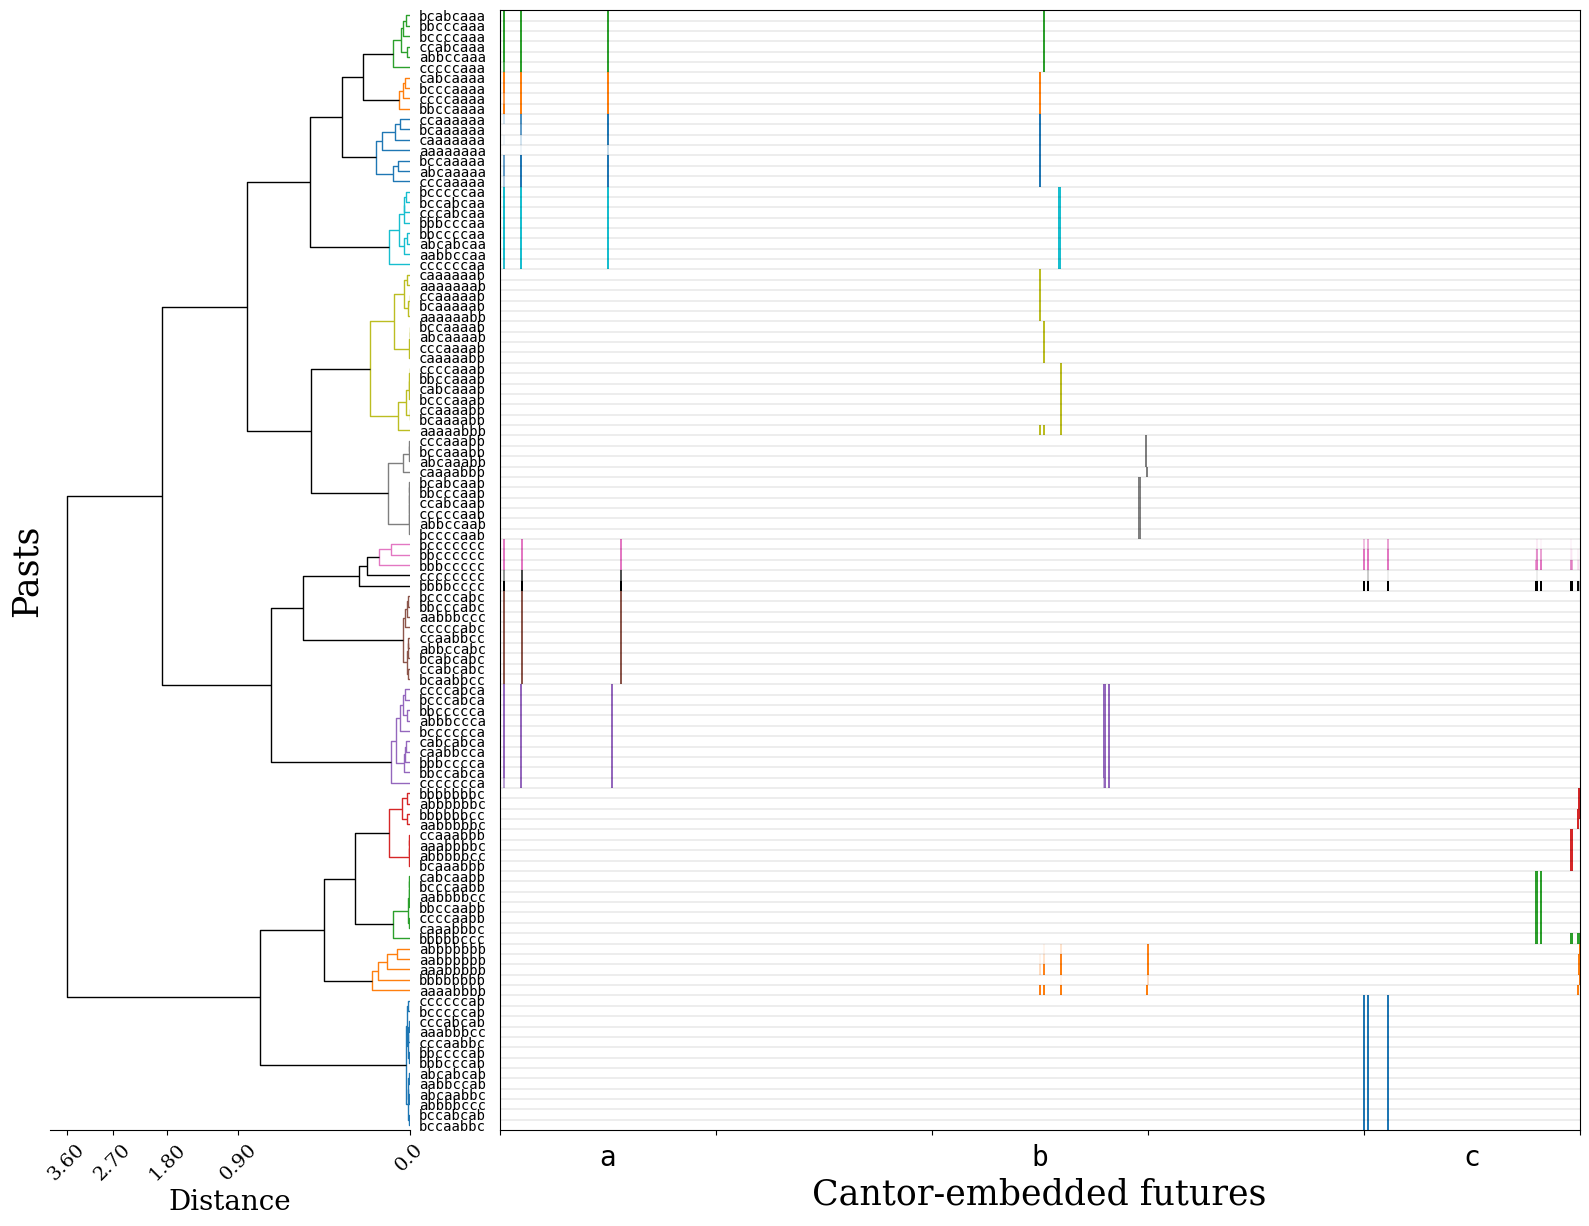

In [21]:
Z,fig = cluster_cantor(unq_pasts,cantors,wass,color_threshold=0.05,matrix_rect=[0.34,0.1,0.6,0.8],)
plt.savefig('../plots/anbncn_HCLUST.png')
plt.show()

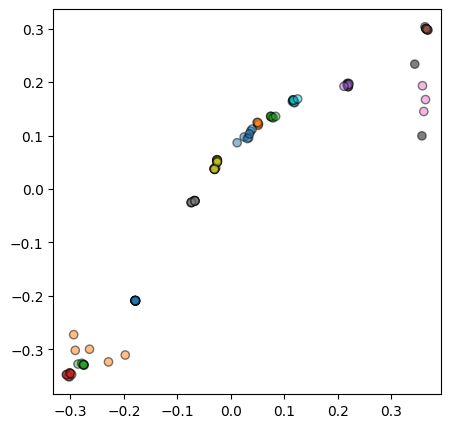

In [22]:
colors_leaves = np.array(Z['leaves_color_list'])
colors = np.empty_like(colors_leaves)
colors[Z['leaves']] = colors_leaves
Y = MDS(n_components=3,dissimilarity='precomputed',random_state=0).fit_transform(squareform(wass))
fig = plt.figure(figsize=(5,5))
plt.scatter(Y[:,0],Y[:,2],edgecolor='k',c=colors,alpha=0.5,)

plt.axis('equal')
plt.savefig('../plots/anbncn_MDS.pdf')
plt.show()

# $x+f(x)$ process

In [23]:
def gen_math_expr(n_iter=10):
    s = 'S;'*n_iter
    return reduce(concat,map(math_grammar,s),'')

def math_grammar(b):
    if b == 'S':
        s = np.random.choice(['S+T','T'],p=[0.3,0.7])
        return reduce(concat,map(math_grammar,s),'')
    elif b == 'T':
        s = np.random.choice(['f(S)','x'],p=[0.5,0.5])
        return reduce(concat,map(math_grammar,s),'')
    else:
        return b

In [24]:
Xs = np.array([x for x in gen_math_expr(80000)])
alphabet = np.unique(Xs)
A = len(alphabet)
print('N = ',Xs.shape[0])

N =  992605


Computing Cantor pairs: 100%|██████████| 9987/9987 [00:00<00:00, 17689.67it/s]


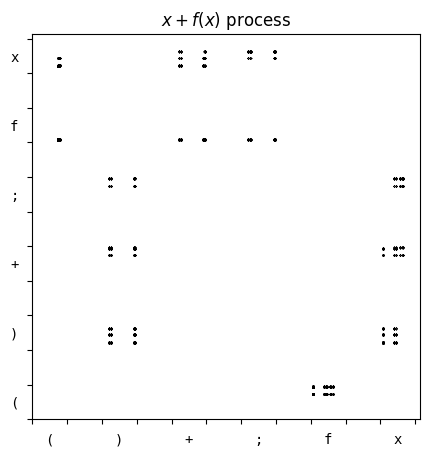

In [25]:
scatter_cantor(Xs[:10000],figsize=(5,5))
plt.title(r'$x+f(x)$ process')
plt.savefig('../plots/x+f(x)_CANTOR.png')
plt.show()

In [26]:
unq_pasts,cantors,wass = CantorWasserstein(PF_pairs(Xs,LP=4,LF=4),)

Evaluating condensed Wasserstein matrix: 100%|██████████| 53/53 [00:10<00:00,  5.16it/s]


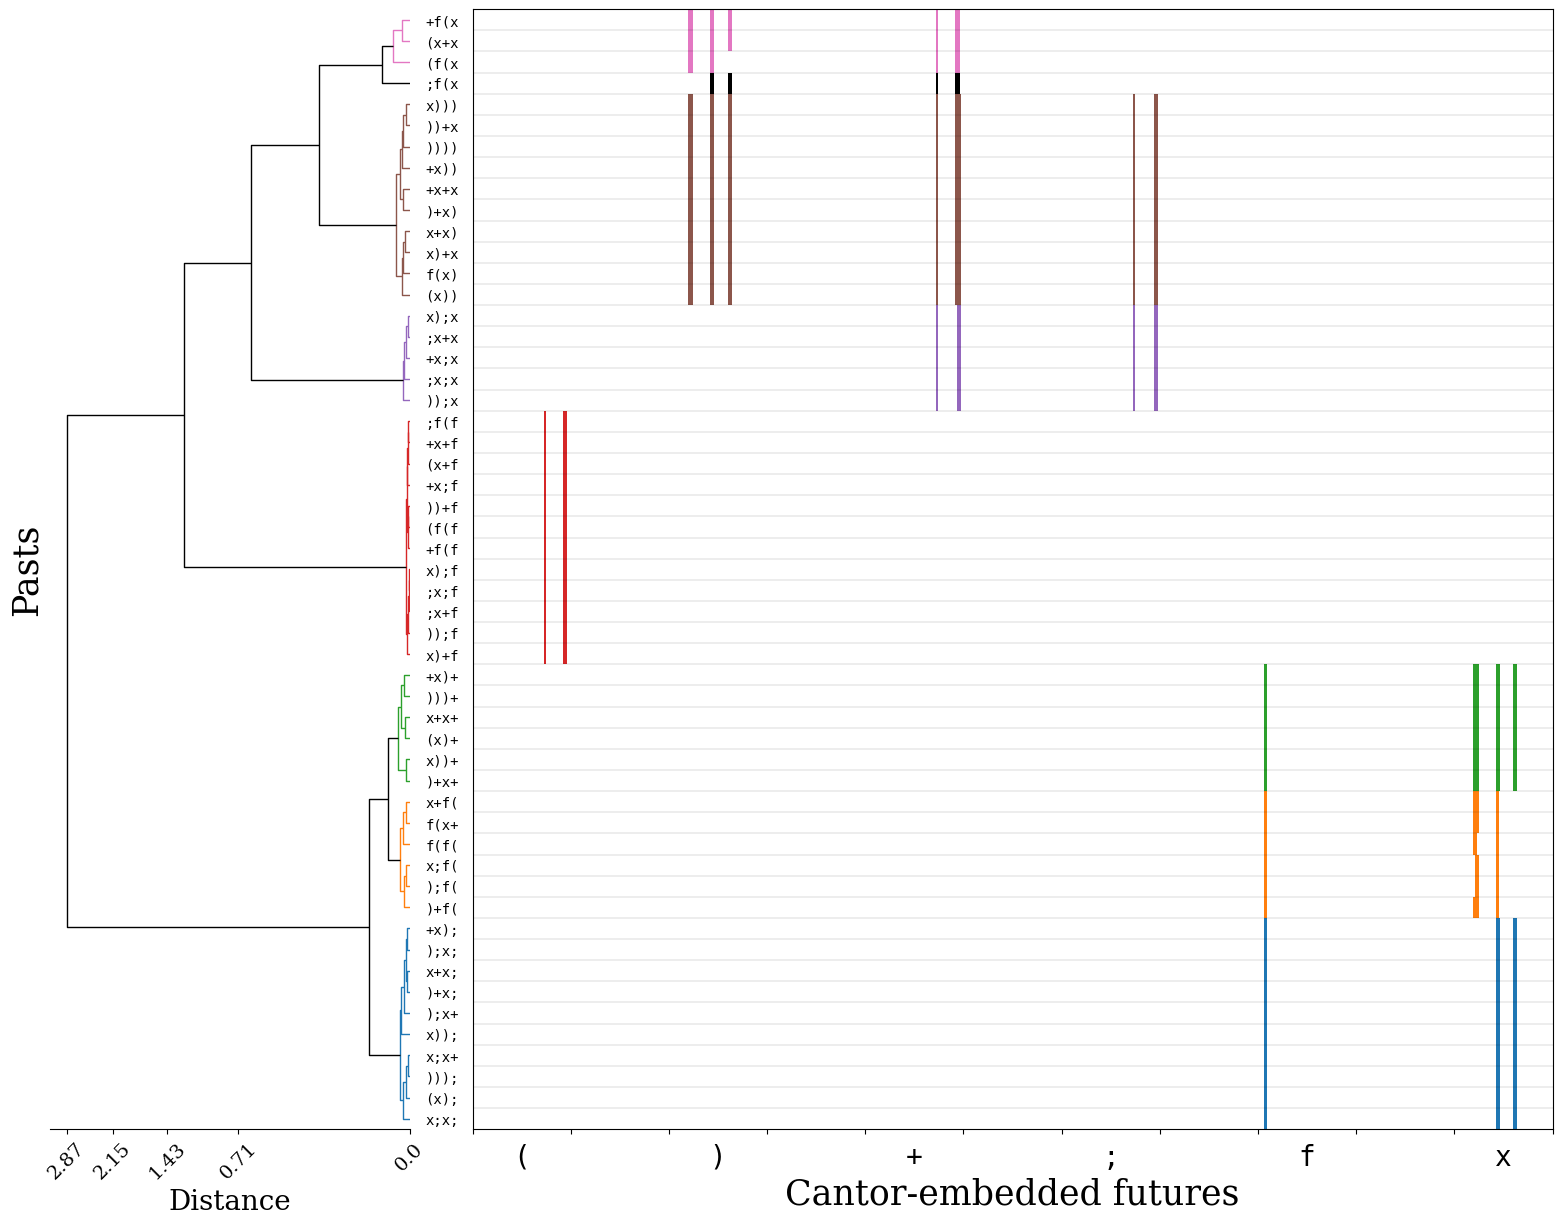

In [27]:
Z,fig = cluster_cantor(unq_pasts,cantors,wass,color_threshold=0.7*(1/8)**2)
plt.savefig('../plots/x+f(x)_HCLUST.png')
plt.show()

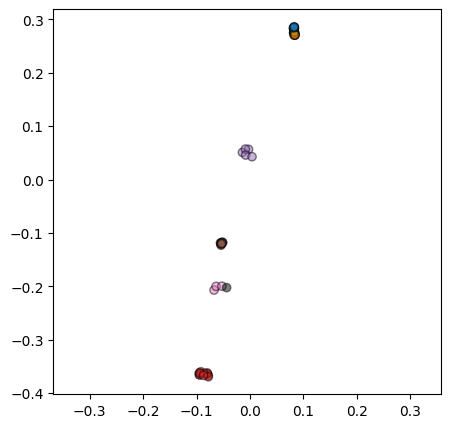

In [28]:
colors_leaves = np.array(Z['leaves_color_list'])
colors = np.empty_like(colors_leaves)
colors[Z['leaves']] = colors_leaves
Y = MDS(n_components=3,dissimilarity='precomputed',random_state=0).fit_transform(squareform(wass))
fig = plt.figure(figsize=(5,5))
plt.scatter(Y[:,0],Y[:,2],edgecolor='k',c=colors,alpha=0.5,)

plt.axis('equal')
plt.savefig('../plots/x+f(x)_MDS.pdf')
plt.show()

# Feigenbaum process

In [29]:
def feig_grammar(b):
    if b == '0':
        return '11'
    elif b == '1':
        return '01'

def gen_feig_expr(n_double=10):
    return reduce(lambda s,f:reduce(concat,map(f,s),''),[feig_grammar]*n_double,'0')

In [13]:
Xs = np.array([x for x in gen_feig_expr(18)])
alphabet = np.unique(Xs)
A = len(alphabet)
print('N = ',Xs.shape[0])

N =  262144


Computing Cantor pairs: 100%|██████████| 9987/9987 [00:00<00:00, 13334.88it/s]


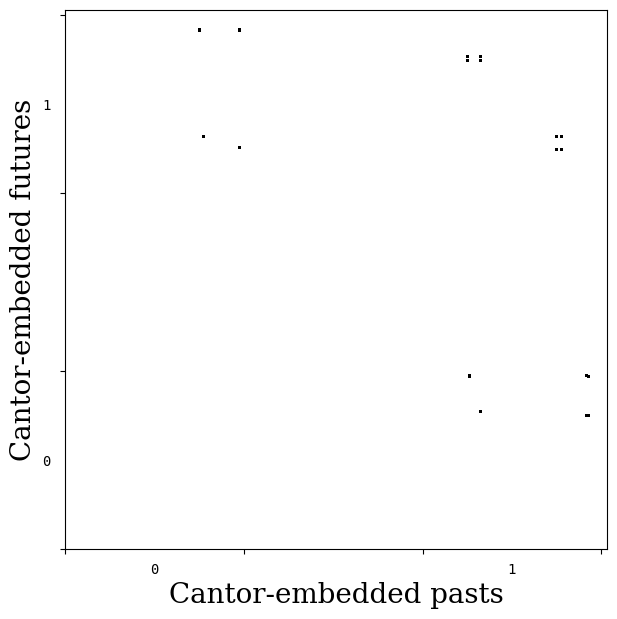

In [41]:
scatter_cantor(Xs[:10000],figsize=(7,7))
plt.savefig('../plots/feig_CANTOR.pdf')
plt.show()

Evaluating condensed Wasserstein matrix: 100%|██████████| 82/82 [00:01<00:00, 44.32it/s]


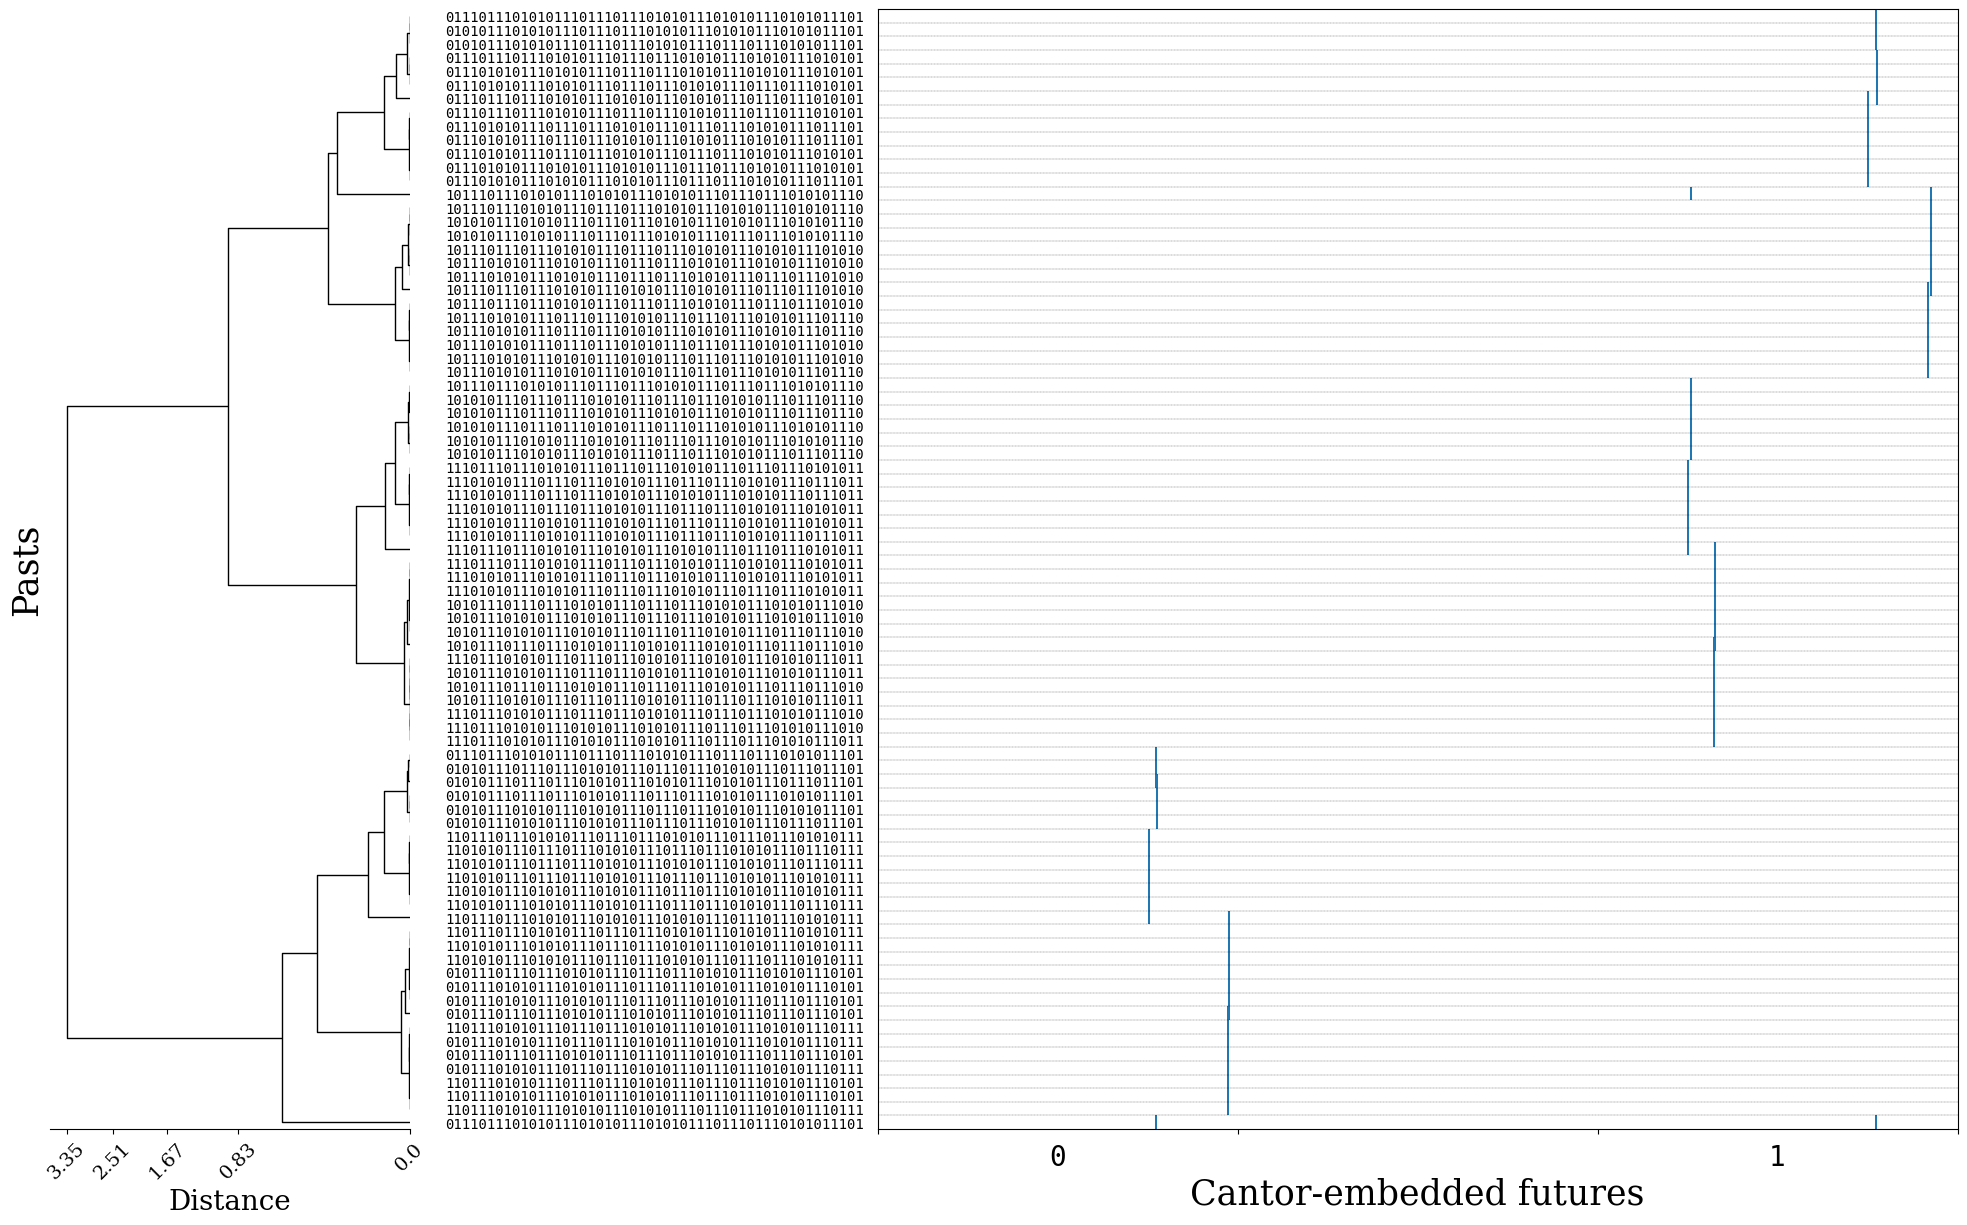

In [14]:
unq_pasts,cantors,wass = CantorWasserstein(PF_pairs(Xs,LP=50,LF=50),)
cluster_cantor(unq_pasts,cantors,wass,matrix_rect=[0.55,0.1,0.6,0.8])
plt.savefig('../plots/feig_HCLUST.pdf')
plt.show()

In [31]:

Y = MDS(n_components=2,dissimilarity='precomputed',random_state=0).fit_transform(squareform(wass))
Z = sch.linkage(wass,method='ward')
cluster_ids = sch.fcluster(Z,t=0.07,criterion='distance')

In [32]:
r = 3.56995
x = np.random.rand(10000)
init_samples = 5000
vis_samples = 50
samples = ['']*len(x)
for _ in range(init_samples):
    x = r*x*(1-x)
for _ in range(vis_samples):
    x = r*x*(1-x)
    samples = [s1+s2 for s1,s2 in zip(samples,((x>0.5).astype(int)).astype(str))]
samples = np.array(samples)

In [33]:
unq_pasts = np.array([''.join(s) for s in unq_pasts])

In [34]:
sample_ids = cluster_ids[[np.where(unq_pasts==s)[0][0] for s in samples]]

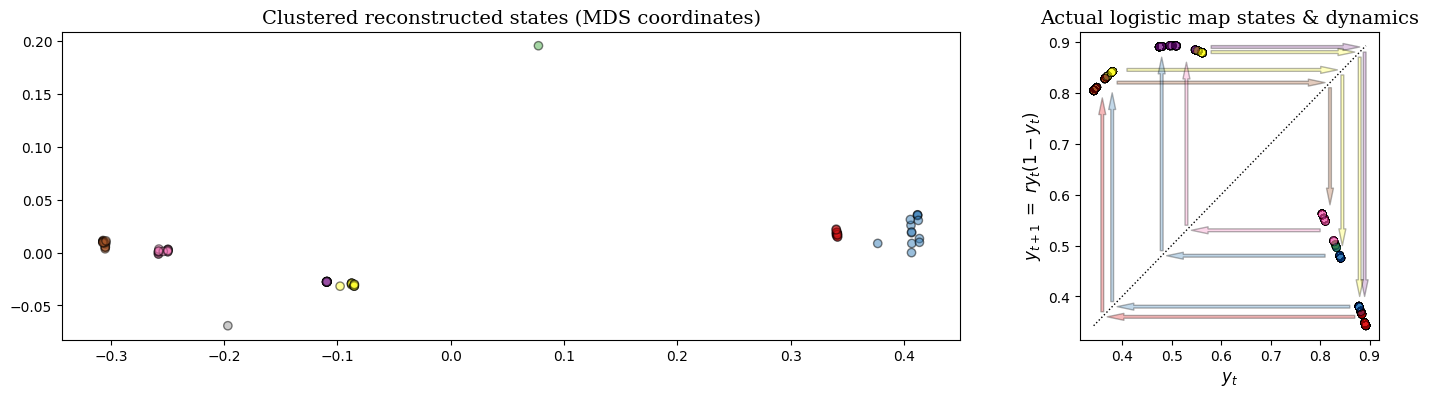

In [75]:

plt.rcParams['text.usetex'] = False

fig,axs = plt.subplots(1,2,figsize=(17,4),gridspec_kw=dict(width_ratios=[3,1]))
xrange = np.linspace(np.min(x),np.max(x),2)
axs[0].scatter(Y[:,0],Y[:,1],edgecolor='k',alpha=0.5,c=cluster_ids,cmap='Set1')
axs[0].set_title('Clustered reconstructed states (MDS coordinates)',fontsize=14,fontfamily='serif')
axs[1].scatter(x,r*x*(1-x),edgecolor='k',linewidth=0.5,alpha=0.01,c=sample_ids,cmap='Set1')
axs[1].plot(xrange,xrange,c='k',linewidth=1,linestyle=':')
axs[1].set_ylabel(r'$y_{t+1}\ =\ ry_t(1-y_t)$',fontsize=12,fontfamily='serif')
axs[1].set_xlabel(r'$y_t$',fontsize=12,fontfamily='serif')
axs[1].set_title(r'Actual logistic map states & dynamics',fontsize=14,fontfamily='serif')

lax = axs[1]
alpha=0.3
lax.annotate('', xy=(0.88, 0.89),  xycoords='data',
            xytext=(0.58, 0.89), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(3/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.89, 0.4),  xycoords='data',
            xytext=(0.89, 0.88), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(3/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.87, 0.88),  xycoords='data',
            xytext=(0.58, 0.88), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(5/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.88, 0.4),  xycoords='data',
            xytext=(0.88, 0.87), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(5/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.835, 0.845),  xycoords='data',
            xytext=(0.41, 0.845), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(5/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.845, 0.5),  xycoords='data',
            xytext=(0.845, 0.835), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(5/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )

lax.annotate('', xy=(0.81, 0.82),  xycoords='data',
            xytext=(0.39, 0.82), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(6/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.82, 0.58),  xycoords='data',
            xytext=(0.82, 0.81), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(6/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.54, 0.53),  xycoords='data',
            xytext=(0.8, 0.53), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(7/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.53, 0.86),  xycoords='data',
            xytext=(0.53, 0.54), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(7/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )

lax.annotate('', xy=(0.49, 0.48),  xycoords='data',
            xytext=(0.81, 0.48), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(1/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.48, 0.87),  xycoords='data',
            xytext=(0.48, 0.49), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(1/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.39, 0.38),  xycoords='data',
            xytext=(0.86, 0.38), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(1/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.38, 0.8),  xycoords='data',
            xytext=(0.38, 0.39), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(1/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.37, 0.36),  xycoords='data',
            xytext=(0.87, 0.36), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(0/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
lax.annotate('', xy=(0.36, 0.79),  xycoords='data',
            xytext=(0.36, 0.37), textcoords='data',
            arrowprops=dict(facecolor=get_cmap('Set1')(0/9),alpha=alpha, width=2,headwidth=5),
            horizontalalignment='right', verticalalignment='top',
            )
plt.savefig('../plots/feig_MDS.pdf')
plt.show()